In [1]:
#Loading of libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings

Hello to everyone,

With the work I did this week, I will do a classification project without building any models. So how will you do it? We haven't heard of such a thing! We will do it using only means, medians and quartiles. So how? Come on let's see :)

**What would this value set be if a threshold was requested in Churn?**

In [2]:
#Loading the data set
df = pd.read_csv("../input/churn-123/churn kopyas.csv")

#observation of the first 2 lines
df.head(2)

#Percentage of churn class found in data
(2037) / (7963 + 2037) 

0.2037

In [3]:
#We see how many observations each class passes in the data.
df.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

We dropped some variables from our dataset with the code snippet below. The reason for this is; The id and name variables do not have any positive effect on the model we will install.

In [4]:
#Dropping unrelated variables
need_drops = ["RowNumber",  "Surname","CustomerId"]
df.drop(need_drops, axis=1, inplace=True)

In [5]:
#Questioning of missing values. It does not have any missing value.
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

We have done a normality test below. This is very important to us. Because it will affect the success of the model. This is the test we did; shows whether the variables (columns) are distributed normally. Interpreting the results of our transaction; H0 is rejected because the pvalue values ​​of all variables are less than 0.05 in the normality tests. So all variables are not distributed normally.

In [6]:
#Test of normality

for i in ['CreditScore' , 'Age', 'Balance', 'EstimatedSalary']:
    print(i)
    t_test , p_value = shapiro(df[i])
    print('Test İstatistiği = %.4f, p-değeri = %.4f' % (t_test, p_value))

CreditScore
Test İstatistiği = 0.9939, p-değeri = 0.0000
Age
Test İstatistiği = 0.9441, p-değeri = 0.0000
Balance
Test İstatistiği = 0.8456, p-değeri = 0.0000
EstimatedSalary
Test İstatistiği = 0.9566, p-değeri = 0.0000


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


With the one_hot_encoder function below; It is the conversion of non-numeric variables in the data to numerical values ​​(0 and 1). This is the language the machine will understand.

In [7]:
def one_hot_encoder(dataframe, category_freq=10, nan_as_category=False):
    categorical_cols = [col for col in dataframe.columns if len(dataframe[col].value_counts()) < category_freq
                        and dataframe[col].dtypes == 'O']

    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=nan_as_category, drop_first=True)

    return dataframe

df = one_hot_encoder(df)

#first two observations
df.head(2)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0


With histogram, the distortions in the data are visually examined.

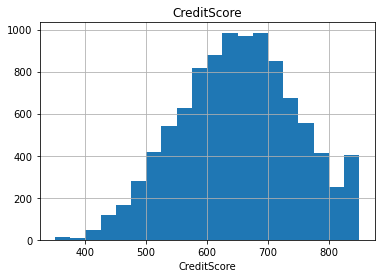

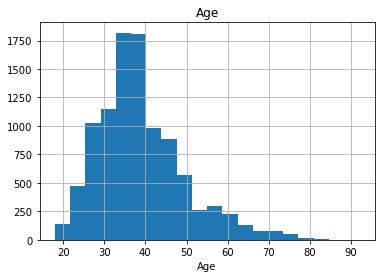

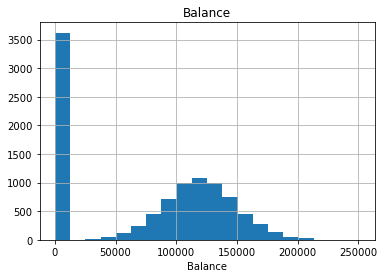

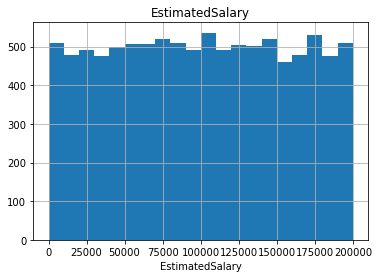

4 variables have been plotted


In [8]:
#Drawing histogram
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


#Drawing a histogram for numerical variables.

a = ['CreditScore' , 'Age', 'Balance', 'EstimatedSalary']

hist_for_nums(df, a)  

With the violin graph, we analyzed the states of the variables in the data according to the target variable.

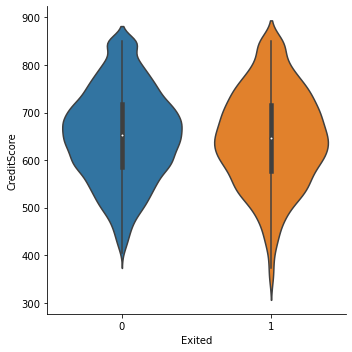

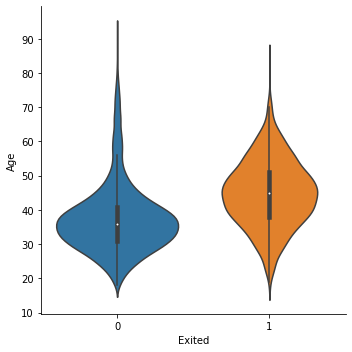

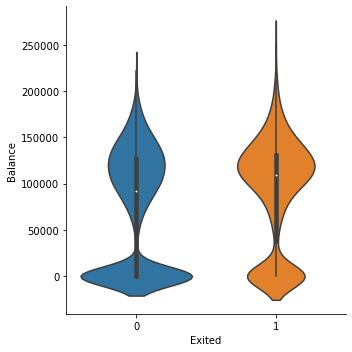

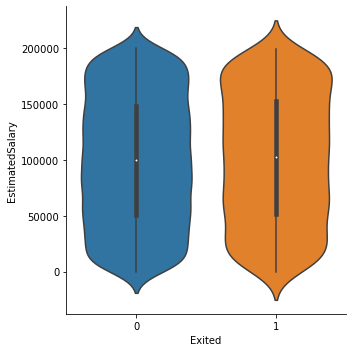

In [9]:
for i in a:
    sns.catplot(x ="Exited" , y= i ,data = df , kind="violin")
    plt.show()

In [10]:
#Calculating correlations
df.corr().T

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.000567,0.003868,0.014733
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
Geography_Germany,0.005538,0.046897,-0.000567,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


# MODELLING

In [11]:
#In order to prepare for the model, we distinguish between the target variable and our independent values.
X = df.drop(['Exited'], axis=1)
y = df[["Exited"]]

#Dividing the data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y , random_state=46)


In [12]:
# LightGBM

#Create a model
lgbm = LGBMClassifier(random_state=12345)
cross_val_score(lgbm, X, y, cv=10).mean()

# model tuning
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1000],
               "max_depth": [3, 5]}

#Calculation of GridSearchCV
gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,
                     n_jobs=-1,
                     verbose=2).fit(X, y)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   18.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The graphic created below is very important to us. Because it shows the importance levels of the variables. On the other hand, we will select 3 variables with high importance and perform a completely manual classification process.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


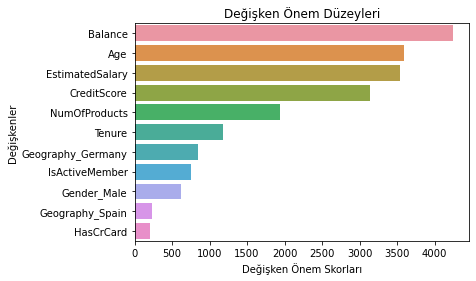

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [13]:
#Building models with the best parameters
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X_train, y_train)
cross_val_score(lgbm_tuned, X_test, y_test, cv=10).mean()


feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

#Graphical representation of variable significance levels
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Değişken Önem Skorları')
plt.ylabel('Değişkenler')
plt.title("Değişken Önem Düzeyleri")
plt.show()

#cv operations (crossing)
kfold = KFold(n_splits=10, random_state=123456)
cv_results = cross_val_score(LGBMClassifier(), X_train, y_train, cv=kfold, scoring="accuracy")


In the Lightgbm algorithm, we select the variables that are most important to us with FeatureImportance option. These variables are Age, Balance and EstimatedSalary.

In [14]:
#Choosing high level of importance variables
df = df[["Age","Balance","EstimatedSalary","Exited"]]
df.head()

,Age,Balance,EstimatedSalary,Exited
0,42,0.00,101348.88,1
1,41,83807.86,112542.58,0
2,42,159660.80,113931.57,1
3,39,0.00,93826.63,0
4,43,125510.82,79084.10,0


Now we might think that why do we create a threshold value?

This is because; It is the process of determining the limit to separate the classes of each variable and classifying them manually according to these values. Now the following may come to mind; Why did you use median instead of mean? This is because; We did the normality test at first and found that it was not distributed normally. When the data is not distributed normally, an intervening large value causes the mean to deviate. For this, I took the median value. But I didn't do this classically by taking the median of a variable. I did it like this; I found the median values ​​of classes 0 and 1 and by taking the average of them, I reached a healthier result. This is the average I get; it created the threshold value that initially demarcated my data. So he separated the 0 and 1 classes. But the threshold process is not over yet. Lets continue :)

In [15]:
#Finding the threshold value according to the age variable
df.groupby("Exited").agg({"Age":"median"}).values.mean()


40.5

In [16]:
#Finding the threshold value according to the balance variable
df.groupby("Exited").agg({"Balance":"median"}).values.mean()

100710.98499999999

In [17]:
#Finding threshold value according to EstimatedSalary variable
df.groupby("Exited").agg({"EstimatedSalary":"median"}).values.mean()

101052.94

The 3 cells above formed our first threshold value. We could fill in according to these 3 thresholds and get a low classification success. But here we have to pay attention to this; there is an imbalance between classes in the data. For this, we will use the quartiles and use the values ​​obtained as threshold values. So we will do a classification process by using two threshold values ​​together. Towards class 1 due to the imbalance in the data; So we will get the threshold value from quartiles upwards. You can examine the finishing results by increasing or decreasing the cartridge percentages.

Örnek :

- First threshold  = df.loc[df.Age > 40.5 ,"Age"]
- Second threshold = df.loc[df.Age > 40.5 ,"Age"].quantile(0.90)

Classification achievements corresponding to various quartile values:

- Classification success when 20: 70.49
- Classification success when 25: 71.54
- Classification success at 30: 72.86
- Classification success at 50: 76
- Classification success at 60: 77
- Classification success at 80: 78.83
- Classification success at 90: 79.01

In [18]:
#Finding the quartiles as threshold values.
df.loc[df.Age > 40.5 ,"Age"].quantile(0.90) 
df.loc[df.Balance > 100710.98499999999 ,"Balance"].quantile(0.90) 
df.loc[df.EstimatedSalary > 101052.94 ,"EstimatedSalary"].quantile(0.90)

190264.86599999998

In [19]:
#We created a new variable by taking a copy of df.
xx = df.copy()

Determination of classes with threshold values ​​obtained using quartile above. Since we use the "&" operator below, classes have been written by applying all the possibilities of the "&" operator so that some variables do not appear as empty classes.

In [20]:
# We're opening an empty column. Because we will perform the classification process with reference to the threshold values.
xx.Exited = np.NaN

xx.loc[(xx.Age > 92) & (xx.Balance > 250898.09) & (xx.EstimatedSalary > 199992.48) , "Exited" ] = 1
xx.loc[(xx.Age > 92.0) & (xx.Balance > 250898.09) , "Exited"] = 1
xx.loc[(xx.Age > 92.0) & (xx.EstimatedSalary > 199992.48) , "Exited"] = 1
xx.loc[(xx.Balance > 250898.09) & (xx.EstimatedSalary > 199992.48) , "Exited"] = 1

xx.loc[(xx.Age <= 92.0) & (xx.Balance <= 250898.09) & (xx.EstimatedSalary <= 199992.48) , "Exited"] = 0
xx.loc[(xx.Age <= 92.0) & (xx.Balance <= 250898.09) , "Exited"] = 0
xx.loc[(xx.Age <= 92.0) & (xx.EstimatedSalary <= 199992.48) , "Exited"] = 0
xx.loc[(xx.Balance <= 250898.09) & (xx.EstimatedSalary <= 199992.48) , "Exited"] = 0

# Assigned class values ​​come in the form of float.
#For the score function, we need to convert it to a categorical variable.

xx.Exited =  xx.Exited.astype('category')
xx.dtypes

Age                   int64
Balance             float64
EstimatedSalary     float64
Exited             category
dtype: object

In [21]:
#Searching for missing values
xx.isnull().sum()

#Total number of observations in the data set
len(xx)

10000

In [22]:
#Comparison of the target variable created using threshold values ​​and the actual target variable y_test
confusion_matrix(xx.Exited, df.Exited)
accuracy_score(xx.Exited, df.Exited)

0.7963

So, classification can be done manually too :)

See you in another article.

linkedin : https://www.linkedin.com/in/mehmet-kele%C5%9F-531032174/